## TensorFlow with Keras

In [47]:
# Import libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # scaling data
from tensorflow import keras
from tensorflow.python.keras.models import Sequential # creating & training a model
from tensorflow.python.keras.layers import Dense #Input
from tensorflow.python.keras.callbacks import EarlyStopping
#from tensorflow.python.keras.activations import sigmoid
#import tensorflow as tf; tf.keras

In [48]:
# Fix the 'DistributedDatasetInterface' Error
from tensorflow.python.keras.engine import data_adapter
def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)
data_adapter._is_distributed_dataset = _is_distributed_dataset

In [49]:
# DATA INGESTION

# Fetch the data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [50]:
# Check the DataFrame
train_df.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


In [51]:
# PREPROCESSING

# Concatenate both training and test data
#data = pd.concat([train_df,test_df]).reset_index(drop=True)

In [52]:
# FEATURE ENGINEERING

# Drop non interested columns
#data.drop(['Name','Cabin'], axis=1, inplace=True)
#data.head()

In [53]:
# split the training and test data again
#train_df = data[data.Survived != -1].reset_index(drop=True) 
#test_df = data[data.Survived == -1].reset_index(drop=True)

In [54]:
# CROSS-VALIDATION

In [55]:
#X = train_df[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']].values
X = pd.get_dummies(train_df[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']])

y = train_df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
X_train.shape

(596, 5)

In [57]:
X_test.shape

(295, 5)

In [58]:
#help(MinMaxScaler)

In [59]:
scaler = MinMaxScaler()

In [60]:
scaler.fit(X_train)

MinMaxScaler()

In [72]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/anna_verbytska/Documents/Titanic-Machine_Learning-from-Disaster/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/anna_verbytska/Documents/Titanic-Machine_Learning-from-Disaster/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [63]:
X_train.min()

nan

In [64]:
# BUILDING A MODEL

#help(Sequential)

In [65]:
# Building a model with 3 layers
model=Sequential()

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) # activation for binary classification problem

#model.compile(optimizer='rmsprop', loss='binary_crossentropy') # loss for binary classification problem
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
early_stop = EarlyStopping(monitor='loss', patience=10)
#model.fit(X_train, y_train, epochs=250, callbacks=[early_stop])
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/250
19/19 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.6258 - val_loss: nan - val_accuracy: 0.5932
Epoch 2/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 3/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 4/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 5/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 6/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 7/250
19/19 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.6275 - val_loss: nan - val_accuracy: 0.5932
Epoch 8/250
19/19 [==============================] - 0s

<Axes: >

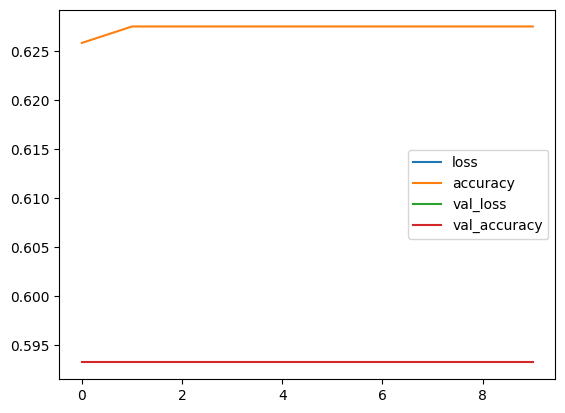

In [67]:
loss_df=pd.DataFrame(model.history.history)
#loss_df[['loss', 'val_loss']].plot(title='Loss Over Epochs')
#loss_df[['accuracy', 'val_accuracy']].plot(title='Accuracy Over Epochs')
loss_df.plot()

#### Note:
Graph 1 (without early stopping)
- The loss is consistently decreasing, which suggests that the model is learning and improving its performance over time.
- the loss is steadily decreasing, but at a slower rate after a certain point - use early stopping to stop training when the loss plateaus, preventing unnecessary epochs.
- Make sure to monitor performance on a validation set to check for overfitting. If the validation loss starts increasing while the training loss keeps decreasing, it may indicate overfitting.

Graph 2 (with early stopping):
- The loss decreases steadily over time, which is a positive sign that the model is learning and converging as expected.
- The training appears to have stopped before the full 250 epochs, which means early stopping has correctly identified when the model's loss was no longer decreasing significantly. This helps prevent overfitting and saves computational resources.
- The small oscillations are normal and expected in training, especially when using optimizers that adjust the weights dynamically.

In [68]:
# Model evaluation on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)

In [69]:
# Calculate the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

/Users/anna_verbytska/Documents/Titanic-Machine_Learning-from-Disaster/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
# Print the metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Model Evaluation Metrics:
Accuracy: 0.5932
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000

Confusion Matrix:
[[175   0]
 [120   0]]


<Axes: >

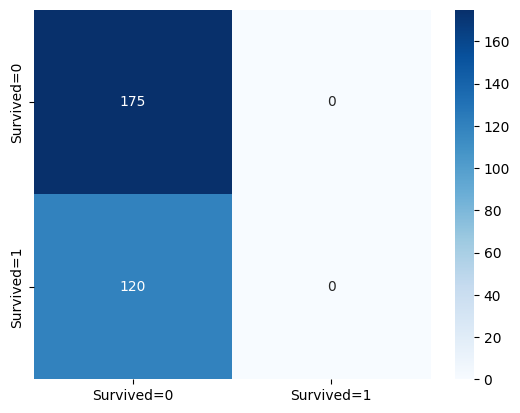

In [71]:
# Optional: Display confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived=0', 'Survived=1'], yticklabels=['Survived=0', 'Survived=1'])